### Introduction to Autoencoders

This tutorial introduces autoencoders with three examples: the basics, **image denoising**, and **anomaly detection**. We will present anomaly detection in this part.

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

![Autoencoders](https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png)

Source: https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f

An optimal autoencoder would perform as close to perfect reconstruction as possible, with "close to perfect" defined by the reconstruction quality function d.

![Reconstruction](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Source: https://blog.keras.io/building-autoencoders-in-keras.html

https://www.tensorflow.org/tutorials/generative/autoencoder?hl=en#third_example_anomaly_detection

Dataset: ECG5000dataset

http://www.timeseriesclassification.com/description.php?Dataset=ECG5000

This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
RND_STATE = 21
TEST_SIZE = 0.2

### Training an Autoencoder for Anomaly Detection

You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. The abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

In [3]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
raw_data[:, -1]   # Last column of the data

array([1., 1., 1., ..., 0., 0., 0.])

### Get Dataset - Split into data and labels

In [5]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=TEST_SIZE, random_state=RND_STATE)

### Data Preprocessing

In [6]:
# Get max. and min. values from training data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

print("Min. value of the training data", min_val)
print("Max. value of the training data", max_val)

# Data Min-Max scaling
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Reduce the size of the data from float64 to float32
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Min. value of the training data tf.Tensor(-6.2808752, shape=(), dtype=float64)
Max. value of the training data tf.Tensor(7.4021031, shape=(), dtype=float64)


In [7]:
# Set data type of labels from int to bool
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Separate normal and anomalous data for training and test data
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

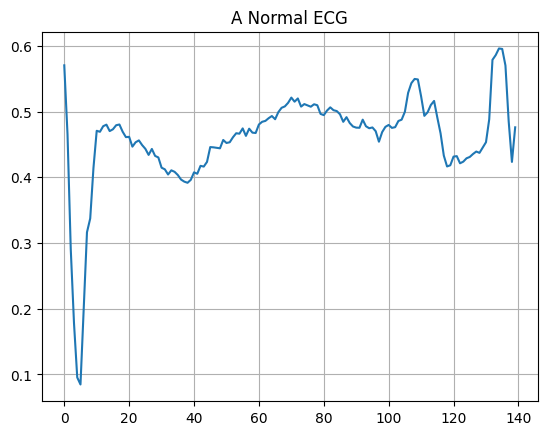

In [8]:
'''
np.arange(start=1, stop=10, step=3)
Output: array([1, 4, 7])
'''

# Plot a normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

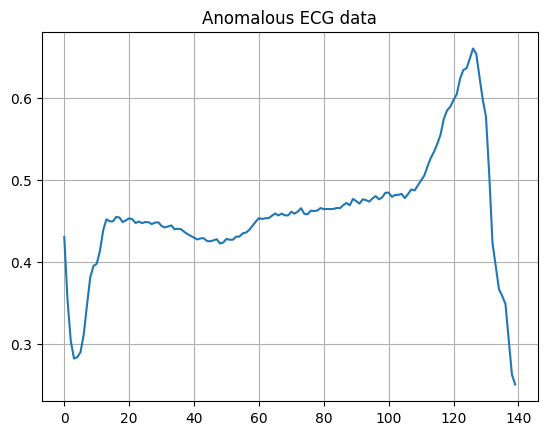

In [9]:
# Plot anomalous ECG data
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("Anomalous ECG data")
plt.show()

### Build the Model

In [20]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()

    self.encoder = tf.keras.Sequential([
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu')
    ])

    self.decoder = tf.keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [21]:
autoencoder = AnomalyDetector()

In [22]:
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 42ms/step - loss: 0.0579 - val_loss: 0.0534
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0562 - val_loss: 0.0519
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0533 - val_loss: 0.0502
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0497 - val_loss: 0.0479
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0455 - val_loss: 0.0458
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0416 - val_loss: 0.0437
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0380 - val_loss: 0.0419
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0346 - val_loss: 0.0405
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0318 - val_loss: 0.0393
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0297 - val_loss: 0.0388
Epoch 11/20
5/5 [============

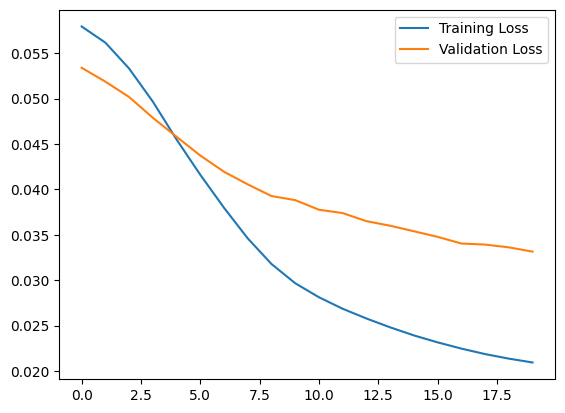

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

### Reconstruction error Graph for Normal Test Data

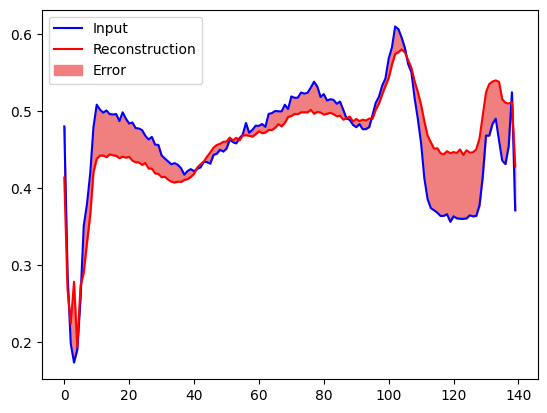

In [24]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

### Reconstruction error Graph for Anomalous Test Data

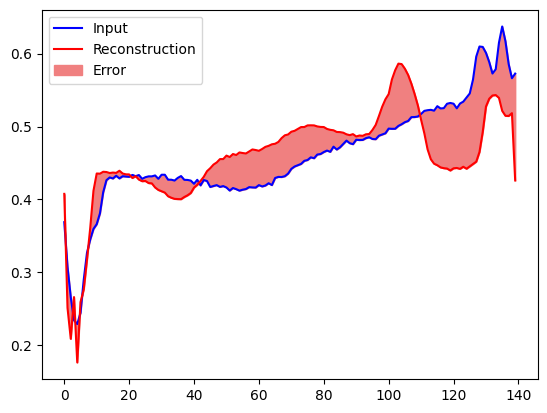

In [26]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

### Detect Anomalies

Detect anomalies by calculating whether the **reconstruction loss** is **greater than a fixed threshold**. In this tutorial, you will calculate the **mean average error** for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

### Plot reconstruction Error for Normal Training data

74/74 [==============================] - 1s 14ms/step


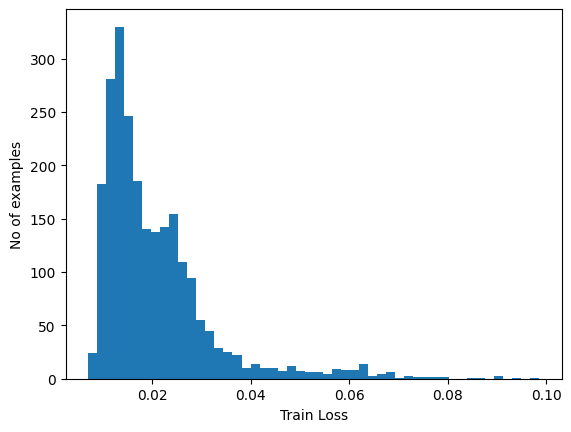

In [37]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)   # Mean Absolute Error => abs(y_true - y_pred)

'''
plt.hist(..., bin=)

(default: 10)
If bins is an integer, it defines the number of equal-width bins in the range.
If bins is a sequence, it defines the bin edges, including the left edge of the
first bin and the right edge of the last bin; in this case, bins may be unequally spaced. 


>> train_loss[:].shape
Output: TensorShape([2359])

>> train_loss[None,:].shape
Output: TensorShape([1, 2359])
'''
plt.hist(train_loss[None, :], bins=50)
plt.xlabel('Train Loss')
plt.ylabel('No of examples')
plt.show()

Choose a threshold value that is one standard deviations above the mean

In [38]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03256798


### Plot reconstruction Error for Anomalous Test data

14/14 [==============================] - 0s 7ms/step


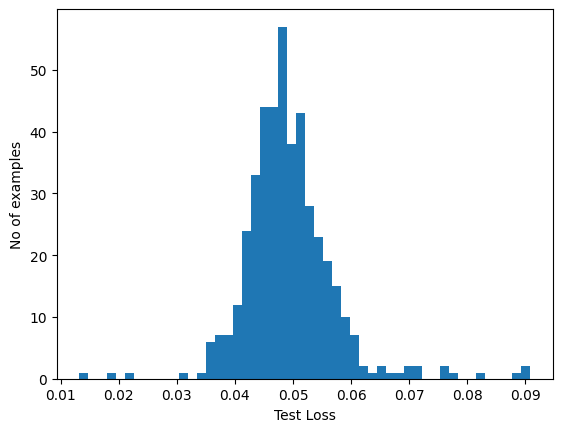

In [40]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test Loss")
plt.ylabel("No of examples")
plt.show()

The reconstruction error for the **anomalous examples** in the **test** set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can **adjust** the **precision** and **recall** of your classifier.

In [41]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)   # Returns the truth value of (x < y) element-wise.

'''
tf.math.less(x, y, name=None)

>> x = tf.constant([5, 4, 6])
>> y = tf.constant([5])
>> tf.math.less(x, y)
Output: [False, True, False]
'''

In [42]:
def print_status(predictions, labels):
  print("Accuracy = {0}".format(accuracy_score(labels, predictions)))
  print("Precision = {0}".format(precision_score(labels, predictions)))
  print("Recall = {0}".format(recall_score(labels, predictions)))

In [43]:
preds = predict(autoencoder, test_data, threshold)
print_status(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


Reference: https://www.tensorflow.org/tutorials/generative/autoencoder?hl=en